In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, DataFrame

In [ ]:
'''
CRISP DM Method -

Barry-Business Understanding
Drove-Data Understanding
Directly to the - Data Preperation
Medical - Modeling 
Emergency - Evaluation
Department - Deployment
'''

'\nCRISP DM Method -\n\nBarry-Business Understanding\nDrove-Data Understanding\nDirectly to the - Data Preperation\nMedical - Modeling \nEmergency - Evaluation\nDepartment - Deployment\n'

##1. Business Understanding

*   Forecasting Transactions
*   Likely regression
*   Data for 3 years
*   Advised data quality is okay

##2. Data Understanding

In [ ]:
import pandas as pd 
import typing 

In [ ]:
'''instantiate spark session as rose'''
rose = SparkSession.builder.master("local[*]").getOrCreate()
rose.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better

In [ ]:
def choose_and_load_csv(file_name:str):
  df = pd.read_csv(f"{file_name}.csv")
  return df 

df_insurance = choose_and_load_csv("insurance")

#df_students = choose_and_load_csv("student-por")

df_journal = choose_and_load_csv("journal_august_21_22")

In [ ]:
df_insurance.isnull().sum(),
#df_students.isnull().sum(),
df_journal.isnull().sum()

entry         0
entry_date    0
dtype: int64

### Read csv into a spark dataframe

In [ ]:
'''#perhaps we can use case whens to label and categorical values that are binary, such 
that, case when df4['smoker'] = 'yes' then 1 else 0'''

def create_df_report_cols(spark:SparkSession, file_name:str)-> DataFrame:
  def read_load(spark:SparkSession, file_name:str)-> DataFrame:
    df = rose.read.format('csv')\
                  .option('header', 'true')\
                  .option('inferSchema', 'true')\
                  .load(f'{file_name}.csv')
    return df

  def select_items(spark:SparkSession, df:DataFrame, col:str):
    #create temp view to traverse sql
    df.createOrReplaceTempView("dataframe")
    df = spark.sql(f"select {col}, count({col}) from dataframe group by {col}")
    df.show()
    return df
  
  df = read_load(spark, file_name)
  #for cols in df.columns:
  #  print(cols)
  #  x = select_items(spark, df, cols)
  #return x 
  return df 

ins_df = create_df_report_cols(rose, "insurance")

journal_df = create_df_report_cols(rose, "journal_august_21_22")

'''df from a csv within the directory, then create a temp view with placeholder name from
that df, then executed a sql query to select the distinct values within each col, and then 
their count. I used a formatted string for the second child function's arg, such that we can 
iterate on the actual return statement of the function.  I then used a for loop to iterate 
over each item(col) in df.columns(which itself returns as a list!)'''


"df from a csv within the directory, then create a temp view with placeholder name from\nthat df, then executed a sql query to select the distinct values within each col, and then \ntheir count. I used a formatted string for the second child function's arg, such that we can \niterate on the actual return statement of the function.  I then used a for loop to iterate \nover each item(col) in df.columns(which itself returns as a list!)"

In [ ]:
'''we are going to use case when statements to convert any categorical data that is binary in 
nature into integer form, so: sex, smoker will be 0 for no, 1 for yes'''

journal_df 

entry,entry_date
Consider the amaz...,2022-08-24 00:56:...
so in the folder ...,2022-08-24 11:28:...
more questions fo...,2022-08-24 12:21:...
"So, I am learning...",2022-08-24 12:26:...
consider the fact...,2022-08-25 22:27:...
this is the actua...,2022-08-25 23:13:...
amazing things on...,2022-08-26 11:39:...
my goal for today...,2022-08-26 11:39:...
Let's consider a ...,2022-08-26 11:44:...
so in a left oute...,2022-08-26 11:49:...


### Calculate Sentiment with TextBlob

In [ ]:
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from textblob import TextBlob
from pyspark.sql.functions import col

In [ ]:
journ_df = journal_df.toPandas()

def add_subj_and_pol(df):
  def get_subjectivity(df):
    subjectivity_list = []
    for entry in journ_df['entry']:
      subjectivity_list.append((TextBlob(entry).sentiment.subjectivity)*100)
    return subjectivity_list

  def get_polarity(df):
    polarity_list = []
    for entry in journ_df['entry']:
      polarity_list.append((TextBlob(entry).sentiment.polarity)*100)
    return polarity_list

  subjectivity_list = get_subjectivity(df)
  polarity_list = get_polarity(df)
  df['entry_subjectivity'] = subjectivity_list
  df['entry_polarity'] = polarity_list
  return df 

    
journal_with_sentiments_df = add_subj_and_pol(journ_df)

journal_with_sentiments_df

,entry,entry_date,entry_subjectivity,entry_polarity
0,Consider the amazing scope of python. I am imp...,2022-08-24 00:56:34.575409,50.000000,35.000000
1,so in the folder 'SPARK_practice' we are imple...,2022-08-24 11:28:58.871384,73.750000,58.125000
2,"more questions for Vinny: first, what is the b...",2022-08-24 12:21:03.607803,23.958333,18.750000
3,"So, I am learning more in depth about Java and...",2022-08-24 12:26:23.632707,50.000000,50.000000
4,consider the fact that when we say if isinstan...,2022-08-25 22:27:02.108078,66.875000,6.250000
5,this is the actual path of THIS file: print(os...,2022-08-25 23:13:06.757321,13.809524,-2.380952
6,amazing things on the horizon: after consultin...,2022-08-26 11:39:05.559125,90.000000,60.000000
7,my goal for today is to do more with SQL and l...,2022-08-26 11:39:53.693929,50.000000,50.000000
8,Let's consider a common scenario of two tables...,2022-08-26 11:44:35.457006,53.240741,-7.777778
9,"so in a left outer join, the rows are still jo...",2022-08-26 11:49:16.816641,26.339286,6.964286


In [ ]:
'''here we added three cols and did polarity(external stimuli to your brain) cut by
the subjectivity or "padding" where you take someone's words with "a grain of salt'''

journal_with_sentiments_df['sentiment'] = journal_with_sentiments_df.entry_polarity / journal_with_sentiments_df.entry_subjectivity

journal_with_sentiments_df = journal_with_sentiments_df.fillna(0)

In [ ]:
'''convert pd df to a spark df'''
journal_with_sentiments_spark = rose.createDataFrame(journal_with_sentiments_df)

In [ ]:
'''create df by selecting cols and converting entry date to type Date,
   then cast with distinct date and convert back into pandas'''
journal_with_sentiments_df_clean = journal_with_sentiments_spark.select(col("entry"),
                                                                        col("entry_date"),
                                                                        col("entry_subjectivity"),
                                                                        col("entry_polarity"),
                                                                        col("sentiment"))\
                                                                .withColumn("entry_date", col("entry_date").cast("Date")).distinct()\
                                                                .fillna(0.00).toPandas()
                                                                

In [ ]:
journal_with_sentiments_df_clean

,entry,entry_date,entry_subjectivity,entry_polarity,sentiment
0,The Spirt of Rose describes a method of user i...,2022-08-29,52.222222,29.444444,0.563830
1,NOTE: SQL stands for Structured Query Language,2022-08-27,0.000000,0.000000,0.000000
2,"select name, bonus from Employee left outer jo...",2022-08-26,36.666667,-15.238095,-0.415584
3,"""so .withColumn(""""date""""",None,0.000000,0.000000,0.000000
4,with DENSE_RANK() we provide a rank but with a...,2022-08-31,82.575758,-64.393939,-0.779817
5,"Good morning, it is truly a beautiful day to b...",2022-09-03,63.598485,39.204545,0.616438
6,"if you haven't noticed, I am using LeetCode fo...",2022-08-26,0.000000,0.000000,0.000000
7,"In general, lets split our logic into as many ...",2022-08-31,66.666667,18.333333,0.275000
8,"""Becuase this is a multi_class classification ...",None,37.500000,-12.500000,-0.333333
9,we are currently working with SQL Case/Whens a...,2022-08-31,70.000000,-50.000000,-0.714286


In [ ]:
#df = df_insurance

#for col in df.columns:
 # print(col, len(df[col].unique()), df[col])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

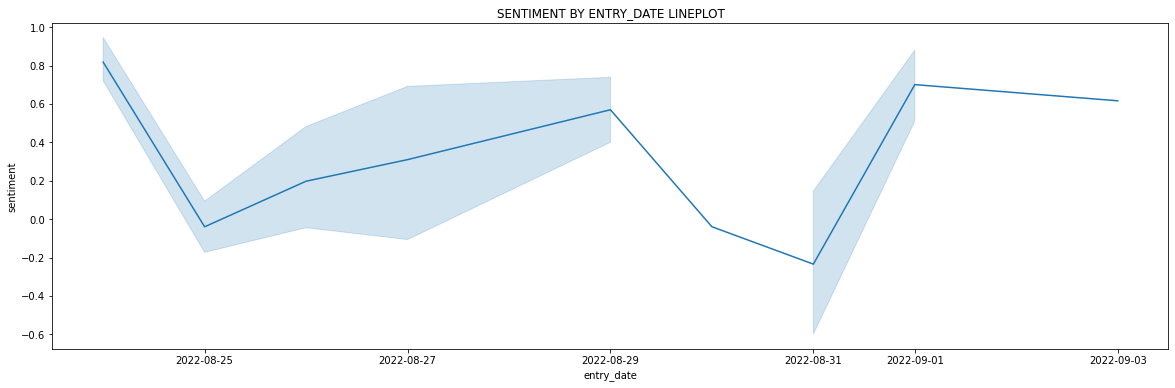

In [ ]:
def visualize_dataframe(df, x_feature, y_feature, type):
  def plot_violin():
    plt.figure(figsize=(20, 6))
    sns.violinplot(x=x_feature, y=y_feature, data=df).set_title(f'{y_feature} by {x_feature} violinplot'.upper())
    plt.show()

  def plot_scatter():
    plt.figure(figsize=(20, 6))
    sns.scatterplot(x=x_feature, y=y_feature, data=df).set_title(f'{y_feature} by {x_feature} scatterplot'.upper())
    plt.show()

  def plot_hist():
    plt.figure(figsize=(20, 6))
    sns.histplot(x=x_feature, y=y_feature, data=df, hue="sentiment").set_title(f'{y_feature} by {x_feature} histogram'.upper())
    plt.show()

  def plot_line():
    plt.figure(figsize=(20,6))
    ax = sns.lineplot(data=df, x="entry_date", y="sentiment")\
            .set_title(f'{y_feature} by {x_feature} lineplot'.upper())
    plt.show()  

  return plot_violin() if type == 'violin' else plot_scatter() if type == 'scatter'\
                       else plot_hist() if type == 'hist'\
                       else plot_line() if type == 'line'\
                       else None 


visualize_dataframe(journal_with_sentiments_df_clean, "entry_date", "sentiment", "line")

In [ ]:
journal_with_sentiments_df_clean.shape[0]

44

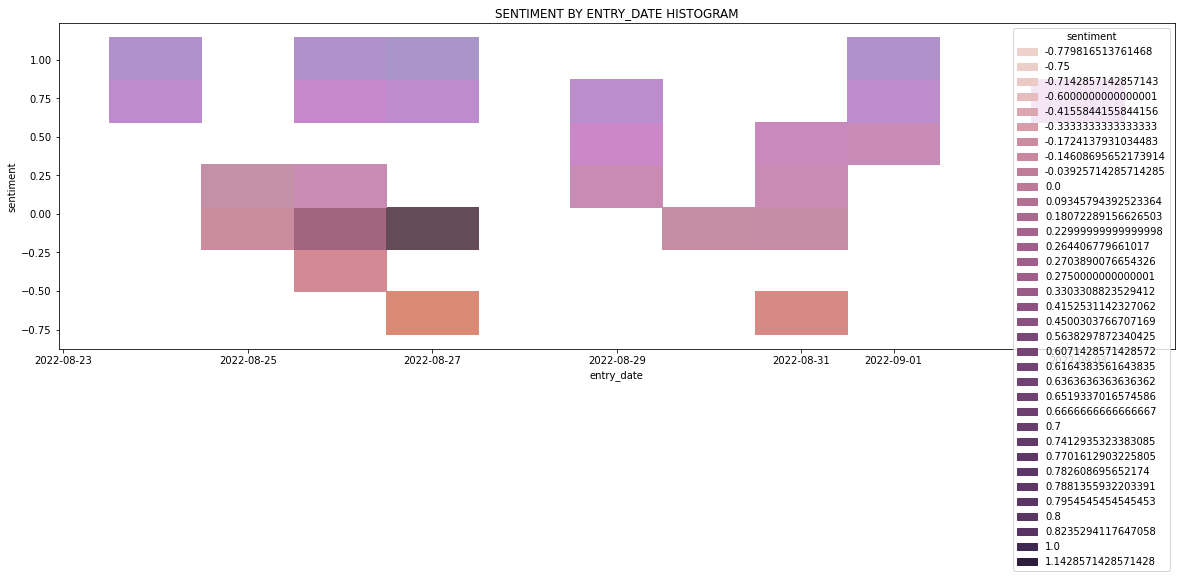

'here we have the shape of the distribution of each feature at a given point in the \ny dimension, in this case at a certain charge.  You can estimate the correlation between the\ndata of the given features based on their visual relation to each other!'

In [ ]:
visualize_dataframe(journal_with_sentiments_df_clean, "entry_date", "sentiment", "hist")

'''here we have the shape of the distribution of each feature at a given point in the 
y dimension, in this case at a certain charge.  You can estimate the correlation between the
data of the given features based on their visual relation to each other!'''

In [ ]:
'''you can estimate from the violinplot that the more homogeneous the datapoints at a given
point on the y axis, the flatter the distribution curve. Theoretically if the datapoints were 
100% homogenous at a certain space on the y-axis, then an acutal curve shape would not exist,
but rather a line shape'''

'you can estimate from the violinplot that the more homogeneous the datapoints at a given\npoint on the y axis, the flatter the distribution curve. Theoretically if the datapoints were \n100% homogenous at a certain space on the y-axis, then an acutal curve shape would not exist,\nbut rather a line shape'

In [ ]:
df_insurance_spark = rose.createDataFrame(df_insurance)

In [ ]:
def binarize_insurance(spark, df):
  def change_smoker(spark, df):
    df.createOrReplaceTempView("insurance")
    df1 = spark.sql("select *, case when smoker = 'yes' then 1 else 0 end as Smoker from insurance")
    df2 = df1.drop(col("insurance.smoker"))
    return df2 

  def change_gender(df):
    from pyspark.sql.functions import when 
    df1 = df.withColumn("gender", when(df.sex == "male", 0)\
                    .when(df.sex == "female", 1)
                    .when(df.sex.isNull() ,"")
                    .otherwise(df.sex))\
                    .drop(df.sex)
    return df1

  df1 = change_smoker(spark, df)
  df2 = change_gender(df1)
  return df2 

In [ ]:
binarized_ins_df = binarize_insurance(rose, df_insurance_spark)
binarized_ins_df.show()

+---+------+--------+---------+-----------+------+------+
|age|   bmi|children|   region|    charges|Smoker|gender|
+---+------+--------+---------+-----------+------+------+
| 19|  27.9|       0|southwest|  16884.924|     1|     1|
| 18| 33.77|       1|southeast|  1725.5523|     0|     0|
| 28|  33.0|       3|southeast|   4449.462|     0|     0|
| 33|22.705|       0|northwest|21984.47061|     0|     0|
| 32| 28.88|       0|northwest|  3866.8552|     0|     0|
| 31| 25.74|       0|southeast|  3756.6216|     0|     1|
| 46| 33.44|       1|southeast|  8240.5896|     0|     1|
| 37| 27.74|       3|northwest|  7281.5056|     0|     1|
| 37| 29.83|       2|northeast|  6406.4107|     0|     0|
| 60| 25.84|       0|northwest|28923.13692|     0|     1|
| 25| 26.22|       0|northeast|  2721.3208|     0|     0|
| 62| 26.29|       0|southeast| 27808.7251|     1|     1|
| 23|  34.4|       0|southwest|   1826.843|     0|     0|
| 56| 39.82|       0|southeast| 11090.7178|     0|     1|
| 27| 42.13|  

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Tokenizer, Word2Vec

In [ ]:
'''In a string indexer vector in pyspark ml, the most frequent value for the column will 
recieve an index of 0'''

'In a string indexer vector in pyspark ml, the most frequent value for the column will \nrecieve an index of 0'

In [ ]:
indexer = StringIndexer(inputCol="region", outputCol="RegionIndex")

df1 = indexer.fit(binarized_ins_df).transform(binarized_ins_df)
df1.show()
#ohe = OneHotEncoder(inputCol="RegionIndex", outputCol="Region_oneHot")

#df_ins = ohe.fit(df).transform(df)

#df_ins.createOrReplaceTempView("data")
#rose.sql("select Region_oneHot from data")
ohe = OneHotEncoder(inputCol="RegionIndex", outputCol="Region_oneHot")

df_ins = ohe.fit(df1).transform(df1)

df_insClean = df_ins.toPandas()
df_insClean


+---+------+--------+---------+-----------+------+------+-----------+
|age|   bmi|children|   region|    charges|Smoker|gender|RegionIndex|
+---+------+--------+---------+-----------+------+------+-----------+
| 19|  27.9|       0|southwest|  16884.924|     1|     1|        2.0|
| 18| 33.77|       1|southeast|  1725.5523|     0|     0|        0.0|
| 28|  33.0|       3|southeast|   4449.462|     0|     0|        0.0|
| 33|22.705|       0|northwest|21984.47061|     0|     0|        1.0|
| 32| 28.88|       0|northwest|  3866.8552|     0|     0|        1.0|
| 31| 25.74|       0|southeast|  3756.6216|     0|     1|        0.0|
| 46| 33.44|       1|southeast|  8240.5896|     0|     1|        0.0|
| 37| 27.74|       3|northwest|  7281.5056|     0|     1|        1.0|
| 37| 29.83|       2|northeast|  6406.4107|     0|     0|        3.0|
| 60| 25.84|       0|northwest|28923.13692|     0|     1|        1.0|
| 25| 26.22|       0|northeast|  2721.3208|     0|     0|        3.0|
| 62| 26.29|       0

,age,bmi,children,region,charges,Smoker,gender,RegionIndex,Region_oneHot
0,19,27.900,0,southwest,16884.92400,1,1,2.0,"(0.0, 0.0, 1.0)"
1,18,33.770,1,southeast,1725.55230,0,0,0.0,"(1.0, 0.0, 0.0)"
2,28,33.000,3,southeast,4449.46200,0,0,0.0,"(1.0, 0.0, 0.0)"
3,33,22.705,0,northwest,21984.47061,0,0,1.0,"(0.0, 1.0, 0.0)"
4,32,28.880,0,northwest,3866.85520,0,0,1.0,"(0.0, 1.0, 0.0)"
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,northwest,10600.54830,0,0,1.0,"(0.0, 1.0, 0.0)"
1334,18,31.920,0,northeast,2205.98080,0,1,3.0,"(0.0, 0.0, 0.0)"
1335,18,36.850,0,southeast,1629.83350,0,1,0.0,"(1.0, 0.0, 0.0)"
1336,21,25.800,0,southwest,2007.94500,0,1,2.0,"(0.0, 0.0, 1.0)"


In [ ]:
def vectorize_text(spark, df, input_col, output_col):
  df0 = spark.createDataFrame(df)
  indexer = StringIndexer(inputCol=input_col, outputCol=output_col)
  #df0.createOrReplaceTempView("d")
  #df1 = spark.sql("select entry from d")
  for rows in df0:
    df2 = indexer.fit(df0).transform(df0)
  return df2


vectorized_journal_df = vectorize_text(rose, journal_with_sentiments_df_clean,
                                       "entry", "entry_vectorized")

In [ ]:
vectorized_journal_df

entry,entry_date,entry_subjectivity,entry_polarity,sentiment,entry_vectorized
The Spirt of Rose...,2022-08-29,52.22222222222223,29.444444444444446,0.5638297872340425,22.0
NOTE: SQL stands ...,2022-08-27,0.0,0.0,0.0,15.0
"select name, bonu...",2022-08-26,36.666666666666664,-15.238095238095237,-0.4155844155844156,37.0
"""so .withColumn(""...",null,0.0,0.0,0.0,3.0
with DENSE_RANK()...,2022-08-31,82.57575757575758,-64.3939393939394,-0.779816513761468,43.0
"Good morning, it ...",2022-09-03,63.59848484848485,39.20454545454545,0.6164383561643835,6.0
if you haven't no...,2022-08-26,0.0,0.0,0.0,30.0
"In general, lets ...",2022-08-31,66.66666666666666,18.333333333333336,0.2750000000000001,10.0
"""Becuase this is ...",null,37.5,-12.5,-0.3333333333333333,0.0
we are currently ...,2022-08-31,70.0,-50.0,-0.7142857142857143,41.0


In [ ]:
tokenizer = Tokenizer(outputCol="text")
tokenizer.setInputCol("entry")
dataframe = tokenizer.transform(vectorized_journal_df)
dataframe

entry,entry_date,entry_subjectivity,entry_polarity,sentiment,entry_vectorized,text
The Spirt of Rose...,2022-08-29,52.22222222222223,29.444444444444446,0.5638297872340425,22.0,"[the, spirt, of, ..."
NOTE: SQL stands ...,2022-08-27,0.0,0.0,0.0,15.0,"[note:, sql, stan..."
"select name, bonu...",2022-08-26,36.666666666666664,-15.238095238095237,-0.4155844155844156,37.0,"[select, name,, b..."
"""so .withColumn(""...",null,0.0,0.0,0.0,3.0,"[""so, .withcolumn..."
with DENSE_RANK()...,2022-08-31,82.57575757575758,-64.3939393939394,-0.779816513761468,43.0,"[with, dense_rank..."
"Good morning, it ...",2022-09-03,63.59848484848485,39.20454545454545,0.6164383561643835,6.0,"[good, morning,, ..."
if you haven't no...,2022-08-26,0.0,0.0,0.0,30.0,"[if, you, haven't..."
"In general, lets ...",2022-08-31,66.66666666666666,18.333333333333336,0.2750000000000001,10.0,"[in, general,, le..."
"""Becuase this is ...",null,37.5,-12.5,-0.3333333333333333,0.0,"[""becuase, this, ..."
we are currently ...,2022-08-31,70.0,-50.0,-0.7142857142857143,41.0,"[we, are, current..."


In [ ]:
!pip install nltk 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import numpy as np 
from nltk.stem import WordNetLemmatizer
def convert_to_array(df, column):
  #select individual col from df
  df0 = df.select(col(column)) 
  #convert df to pandas 
  df1 = df0.toPandas()
  #convert df col to np array
  df2 = np.asarray(df1)
  #flatten() the np array to 1d
  df3 = df2.flatten()
  #convert to a list then a str
  df4 = str(list(df3))
  
  #instantiate the lemmatizer tool and lemmatize the df which is now a string 
  lemmatizer = WordNetLemmatizer()
  df5 = lemmatizer.lemmatize(df4)

  df6 = df5.replace('/', '').replace('.', '').replace('!', '')
  return df6

tokens = convert_to_array(dataframe, "text")
tokens

'[[\'the\', \'spirt\', \'of\', \'rose\', \'describes\', \'a\', \'method\', \'of\', \'user\', \'interaction\', \'that\', \'has\', "rose\'s", \'sentiment,\', \'estimated\', \'logic,\', \'etc\', \'hardcoded\', \'into\', \'the\', \'python\', \'script\', \'i\', \'believe\', \'that\', \'data\', \'interaction\', \'can\', \'be\', \'just\', \'that:\', \'interactive\', \'and\', \'human\', \'\', \'we\', \'must\', \'remember\', \'that\', \'while\', \'data\', \'is\', \'not\', \'itself\', \'living,\', \'it\', \'is\', \'derived\', \'from\', \'living\', \'things\', \'(partially)\', \'thus\', \'we\', \'must\', \'interact\', \'with\', \'this\', \'particular\', \'data\', \'in\', \'the\', \'way\', \'that\', \'\', \'we\', \'would\', \'interact\', \'with\', \'a\', \'semi\', \'living\', \'being\', \'more\', \'to\', \'come\'], [\'note:\', \'sql\', \'stands\', \'for\', \'structured\', \'query\', \'language\'], [\'select\', \'name,\', \'bonus\', \'from\', \'employee\', \'left\', \'outer\', \'join\', \'bonus\', 

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

ps.stem(tokens)

'[[\'the\', \'spirt\', \'of\', \'rose\', \'describes\', \'a\', \'method\', \'of\', \'user\', \'interaction\', \'that\', \'has\', "rose\'s", \'sentiment,\', \'estimated\', \'logic,\', \'etc\', \'hardcoded\', \'into\', \'the\', \'python\', \'script\', \'i\', \'believe\', \'that\', \'data\', \'interaction\', \'can\', \'be\', \'just\', \'that:\', \'interactive\', \'and\', \'human\', \'\', \'we\', \'must\', \'remember\', \'that\', \'while\', \'data\', \'is\', \'not\', \'itself\', \'living,\', \'it\', \'is\', \'derived\', \'from\', \'living\', \'things\', \'(partially)\', \'thus\', \'we\', \'must\', \'interact\', \'with\', \'this\', \'particular\', \'data\', \'in\', \'the\', \'way\', \'that\', \'\', \'we\', \'would\', \'interact\', \'with\', \'a\', \'semi\', \'living\', \'being\', \'more\', \'to\', \'come\'], [\'note:\', \'sql\', \'stands\', \'for\', \'structured\', \'query\', \'language\'], [\'select\', \'name,\', \'bonus\', \'from\', \'employee\', \'left\', \'outer\', \'join\', \'bonus\', 

In [ ]:
def get_vocab(token_set):
  vocab, index = {}, 1
  vocab['<pad>'] = 0 
  for token in token_set:
    if token not in vocab:
      vocab[token] = index 
      index += 1
  vocab_size = len(vocab)
  return vocab 

vocab = get_vocab(tokens)
vocab

In [ ]:
inverse_vocab = {index: token for token, index in vocab.items()}
inverse_vocab

In [ ]:
example_sequence = [vocab[word] for word in tokens]
example_sequence = np.array(example_sequence)
example_sequence

array([ 1,  1,  2, ...,  2, 31, 31])

In [ ]:
#here we have a function that cleans null and casts correct dtypes with spark
def clean_student_data(spark, file_name):
  #replace null values in different cols with spark
  def replace_null(spark, file_name):
    df0 = spark.read.format("csv").option("header", "true")\
                    .option("inferSchema", "true").load(f"{file_name}.csv")
    df0.createOrReplaceTempView("d1")
    df1 = spark.sql("SELECT *, CASE WHEN contact_info = 'NULL' THEN 'contact thru store' else contact_info end as contact FROM d1;")
    df2 = df1.drop(col("contact_info"))
    df2.createOrReplaceTempView("d2")
    df3 = spark.sql("select *, case when lesson_time = 'NULL' then 440 else lesson_time end as time from d2")
    df4 = df3.drop(col("lesson_time"))
    df4.createOrReplaceTempView("d3")
    df5 = spark.sql("select *, case when day_of_study = 'NULL' then 'Thursday' else day_of_study end as lesson_day from d3")\
              .drop(col("day_of_study"))
    df5.createOrReplaceTempView("d4")
    df6 = spark.sql("select *, case when age = 'NULL' then 14.6 else age end as student_age from d4")\
              .drop(col("age"))
    return df6
    
  def standardize_schema(spark, df):
    df0 = df.select("*")\
            .withColumn("date_entered", col("date_entered").cast("Date"))\
            .withColumn("time", col("time").cast("Double"))\
            .withColumn("student_age", col("student_age").cast("Double"))
    return df0

  df_first = replace_null(rose, file_name)
  df_final = standardize_schema(rose, df_first)
  df_final.printSchema()
  df_final.show()
  return df_final 

In [ ]:
clean_student_df = clean_student_data(rose, "students_08142022")

root
 |-- name: string (nullable = true)
 |-- instrument: string (nullable = true)
 |-- date_entered: date (nullable = true)
 |-- keyword_comments: string (nullable = true)
 |-- status: double (nullable = true)
 |-- contact: string (nullable = true)
 |-- time: double (nullable = true)
 |-- lesson_day: string (nullable = true)
 |-- student_age: double (nullable = true)

+------------+----------+------------+--------------------+------+------------------+-----+----------+-----------+
|        name|instrument|date_entered|    keyword_comments|status|           contact| time|lesson_day|student_age|
+------------+----------+------------+--------------------+------+------------------+-----+----------+-----------+
|        Alex|     piano|  2022-08-17|comfortable, crea...|   3.0|        thru store|500.0|         W|        5.0|
|   Cal Moffe|     piano|  2022-08-17|  driven, perceptive|   5.0|              cell|600.0|         W|       60.0|
|   Elizabeth|     piano|  2022-08-17|perceptive, won

In [ ]:
clean_student_data = clean_student_df.toPandas()
pd.get_dummies(clean_student_data['name'])

,Alex,Cal Moffe,Elizabeth,Emma Miller,Isabella,Leah Miller,Marian C,Mason Miller,Soren
0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0
6,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,1


In [ ]:
corrdict = {}

for key, row in clean_student_data.join(pd.get_dummies(clean_student_data['student_age'])).iterrows():
  corrdict[key] = {int(row['student_age']):row['status']}

In [ ]:
corrdict

corrdf = pd.DataFrame(corrdict).T.fillna(0)
corrdf.corr()

,5,60,6,14,9,8
5,1.000000,-0.125000,-0.186551,-0.187112,-0.125000,-0.188563
60,-0.125000,1.000000,-0.186551,-0.187112,-0.125000,-0.188563
6,-0.186551,-0.186551,1.000000,-0.279247,-0.186551,-0.281413
14,-0.187112,-0.187112,-0.279247,1.000000,-0.187112,-0.282260
9,-0.125000,-0.125000,-0.186551,-0.187112,1.000000,-0.188563
8,-0.188563,-0.188563,-0.281413,-0.282260,-0.188563,1.000000


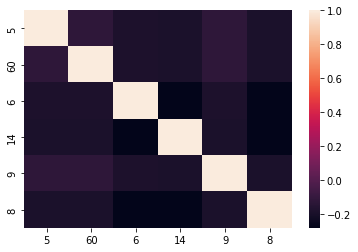

In [ ]:
sns.heatmap(corrdf.corr())

# ##3. Data Preparation

In [ ]:
import numpy as np

In [ ]:
#retrieve all unique ages from this col:
for age in clean_student_data['student_age'].unique():
  print(age)

5.0
60.0
6.0
14.6
9.0
8.0


##4. Modeling

## 5. Evaluation

##6. Deployment

